# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL

# Conexão ao PostgreSQl

In [2]:
# user = "avnadmin"
# password = "AVNS_9fZb3BkX9qGXxKpxsrZ"
# host = "postgresql-iscac.f.aivencloud.com"
# port = "25674"
# bucket = "Seasonality"

# # URL de conexão com PostgreSQL
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{bucket}')

# #Nome da tabela 
# meteorology ='bicycle_counter'

# Importar dados do PostgreSQL

In [3]:
# Como a Api ainda não esta a funcionar, vou importar os dados de um csv
df = pd.read_csv('../all_bike_counts.csv', parse_dates=['detected'], dtype='int32')
df = df.set_index('detected')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22632 entries, 2021-08-01 00:00:00 to 2024-02-29 23:00:00
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   22632 non-null  int32
 1   count_2       22632 non-null  int32
 2   direction_3   22632 non-null  int32
 3   count_3       22632 non-null  int32
 4   direction_4   22632 non-null  int32
 5   count_4       22632 non-null  int32
 6   direction_5   22632 non-null  int32
 7   count_5       22632 non-null  int32
 8   direction_6   22632 non-null  int32
 9   count_6       22632 non-null  int32
 10  direction_7   22632 non-null  int32
 11  count_7       22632 non-null  int32
 12  direction_8   22632 non-null  int32
 13  count_8       22632 non-null  int32
 14  direction_9   22632 non-null  int32
 15  count_9       22632 non-null  int32
 16  direction_10  22632 non-null  int32
 17  count_10      22632 non-null  int32
 18  direction_11  22632 non-null  i

In [4]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

                     direction_2  count_2  direction_3  count_3  direction_4  \
detected                                                                       
2021-08-01 00:00:00            0        0            1        1            0   
2021-08-01 01:00:00            3        3            0        2    

# Decomposição sazonal (STL)

Resultados para count_12:
detected
2021-08-01    456.616114
2021-08-02    -38.682754
2021-08-03    -75.571232
2021-08-04    -62.082525
2021-08-05   -101.170228
Freq: D, Name: season, dtype: float64


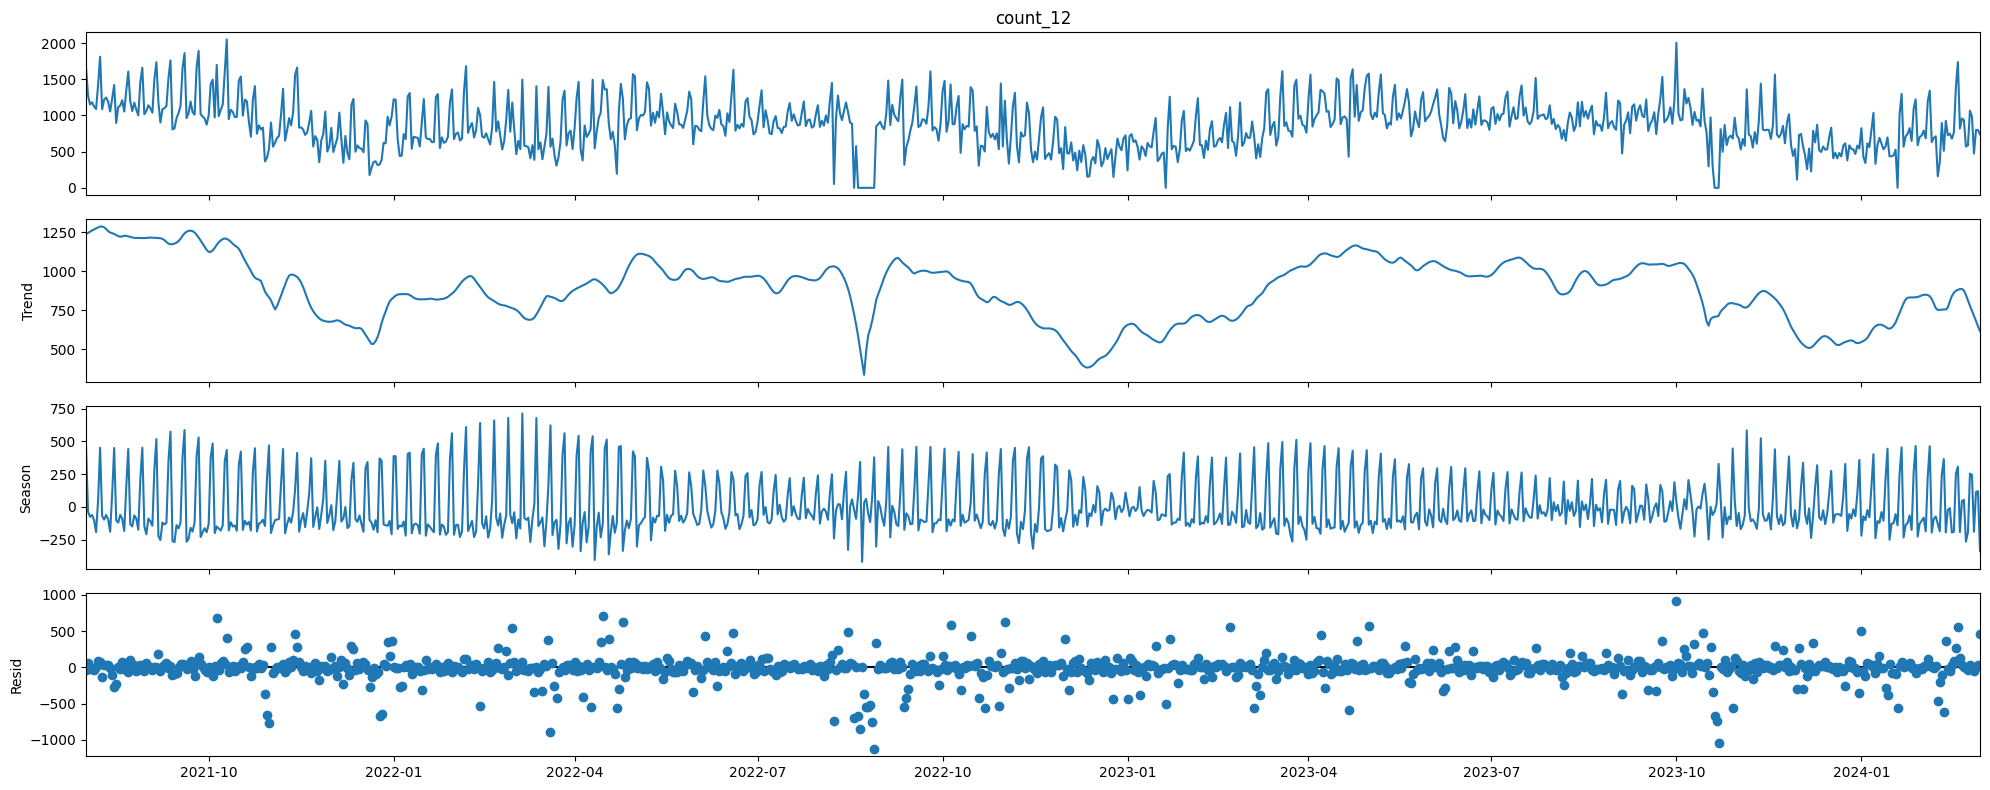

Resultados para count_13:
detected
2021-08-01   -102.005751
2021-08-02     55.830214
2021-08-03     63.427446
2021-08-04     66.965107
2021-08-05      1.664239
Freq: D, Name: season, dtype: float64


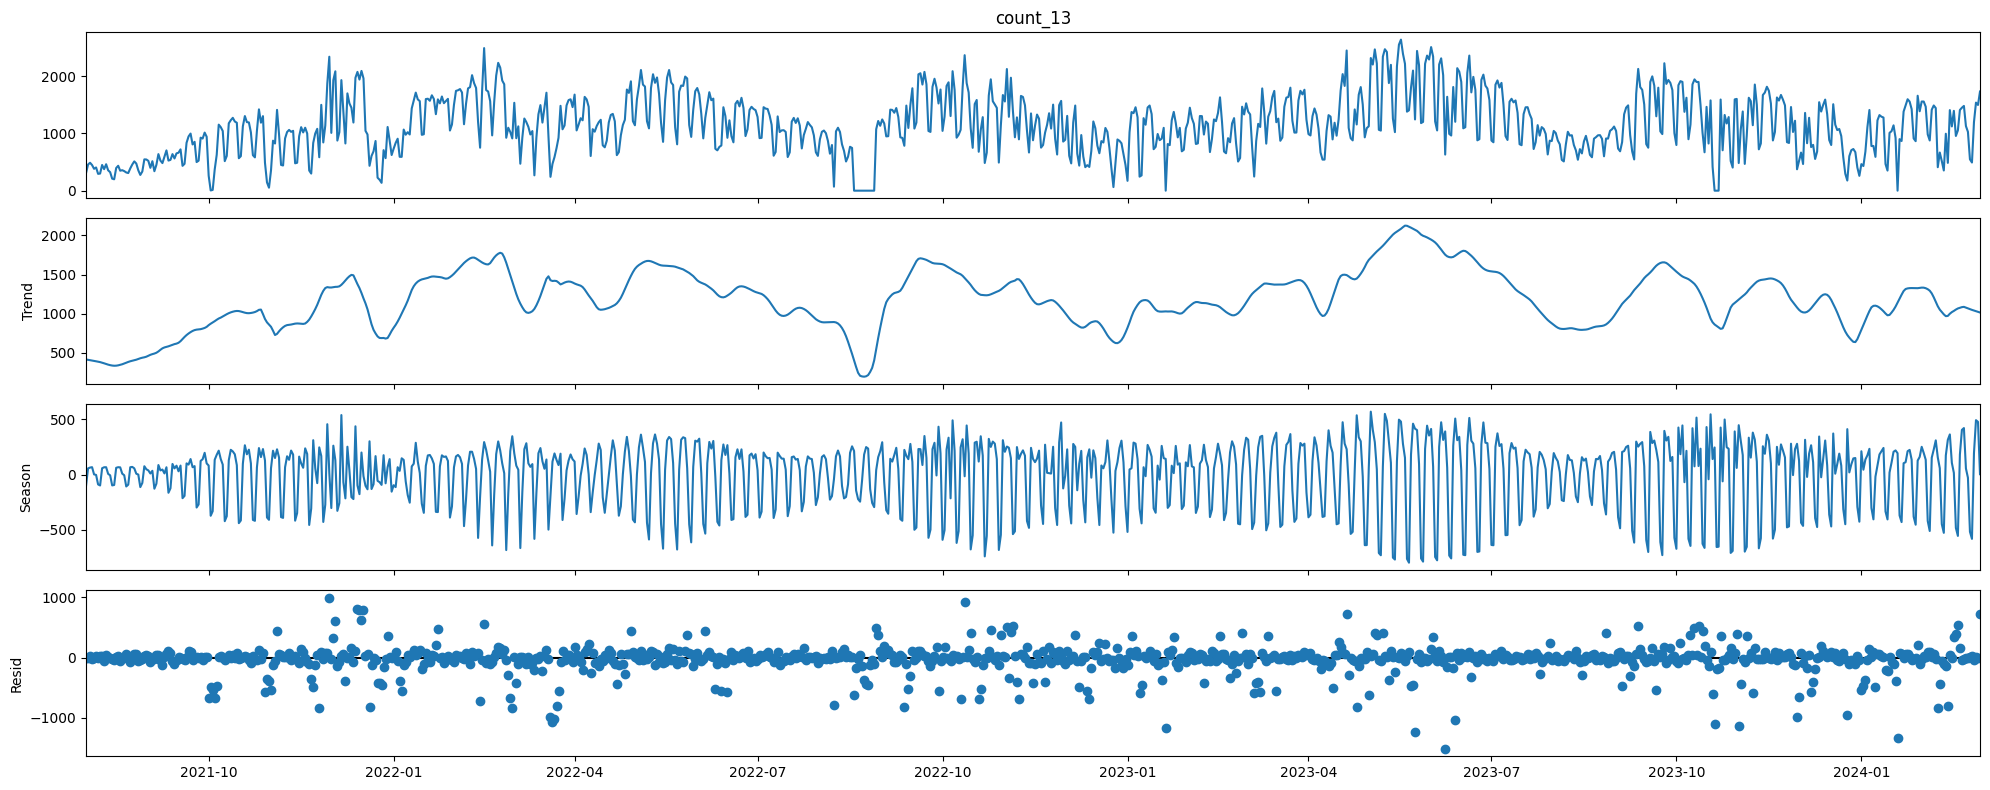

In [5]:

# Faz o resample diário e soma os valores
df_daily = df.resample('D').sum()

location_ids = [12, 13] 

# Gera os nomes das colunas com base nos location_ids escolhidos
contadores = [f"count_{loc}" for loc in location_ids]

# Loop para aplicar STL aos contadores selecionados
for contador in contadores:
    if contador in df_daily.columns:  # Verifica se a coluna existe
        series = df_daily[contador]

        # Aplica STL com sazonalidade semanal (7 dias)
        stl = STL(series, period=7, robust=True)
        res = stl.fit()

        # Exibe os primeiros valores da decomposição sazonal
        print(f"Resultados para {contador}:")
        print(res.seasonal.head())

        # Plota os resultados da decomposição
        fig = res.plot()
        fig.set_size_inches((20, 8))
        plt.tight_layout()
        plt.show()


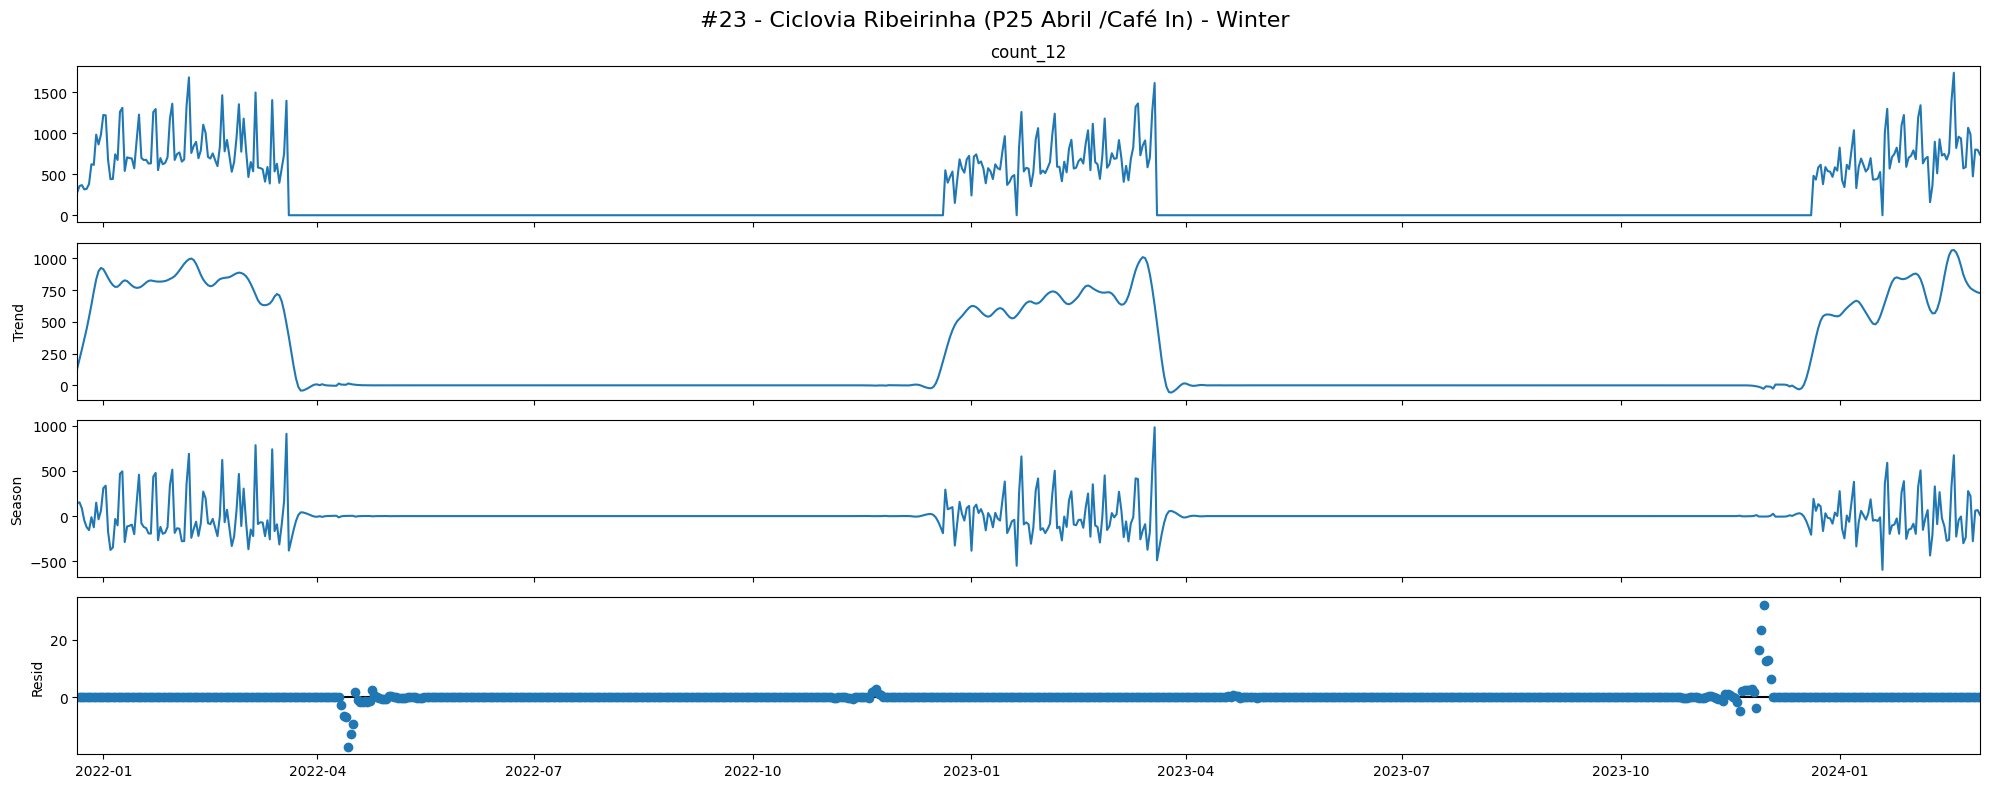

In [6]:
location_id = 12  

location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]  # Obtém o nome da localização

df_winter = df[((df.index.month == 12) & (df.index.day >= 21)) | 
               (df.index.month == 1) | 
               (df.index.month == 2) | 
               ((df.index.month == 3) & (df.index.day <= 19))]

# Agrega os dados por dia
contador = f"count_{location_id}"
series_winter = df_winter.resample('D').sum()[contador]

# Aplicar a decomposição sazonal com período semanal (7 dias)
stl = STL(series_winter, period=7, robust=True)
res = stl.fit()

# Criar a figura 
fig = res.plot()
fig.set_size_inches(20, 8)

plt.suptitle(f'{location_name} - Winter', fontsize=16)
plt.tight_layout()
plt.show()


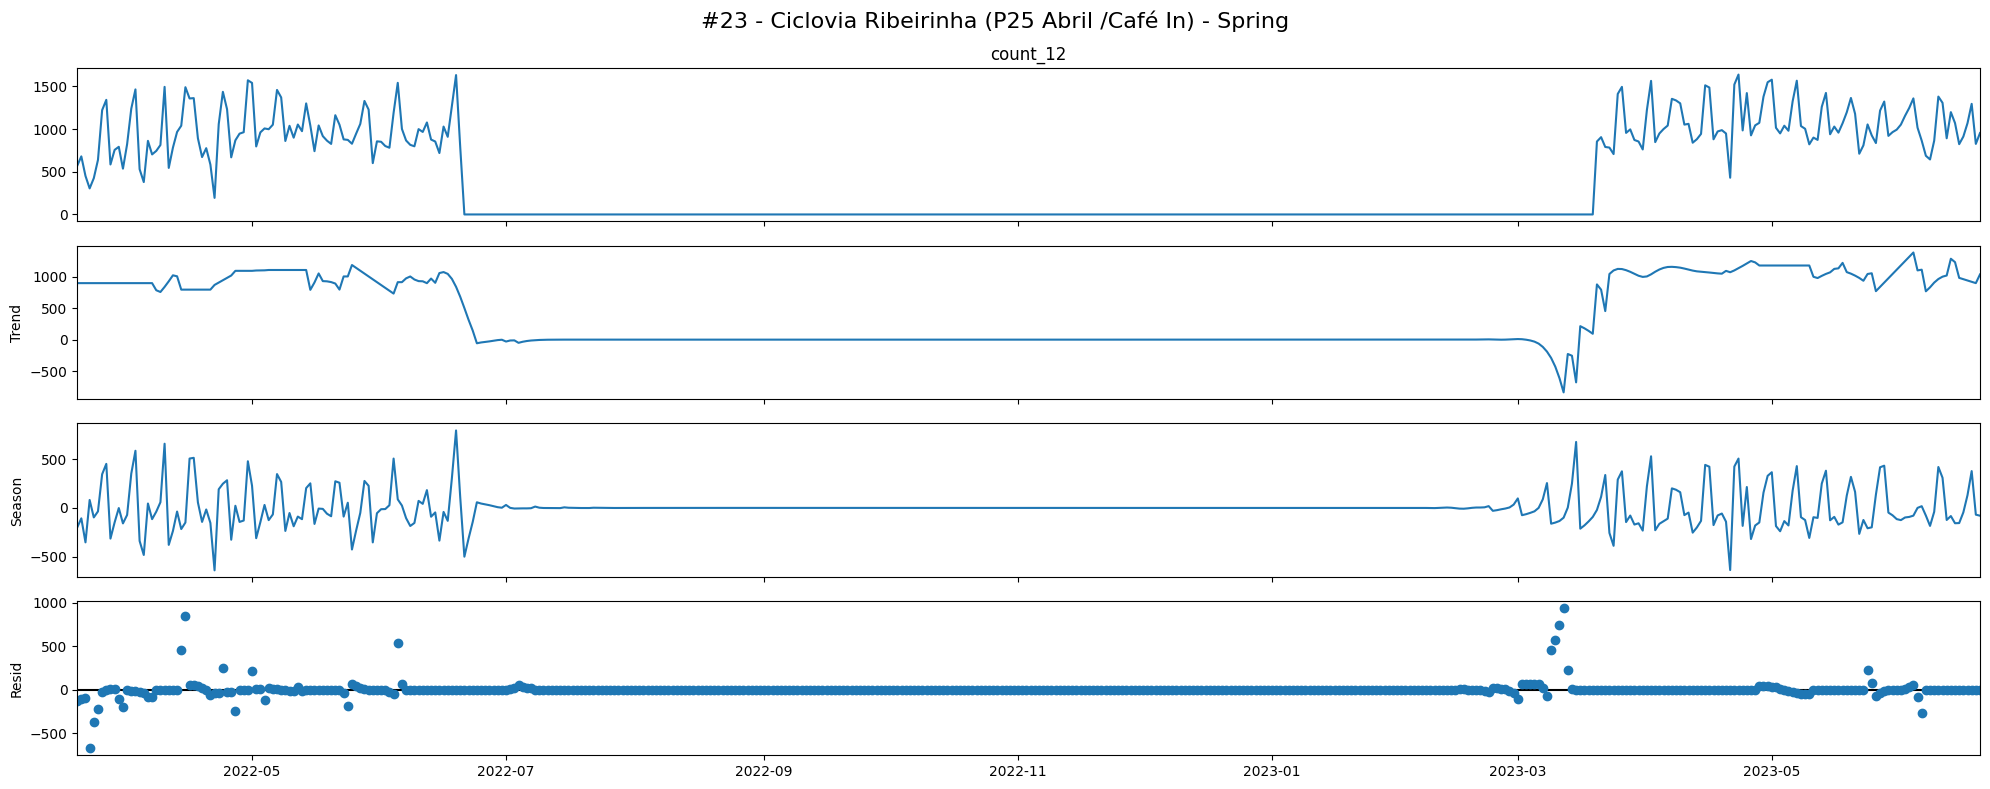

In [8]:
location_id = 12  

location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]  # Obtém o nome da localização

df_spring = df[(df.index.month == 3) & (df.index.day >= 20) |
               (df.index.month == 4) |
               (df.index.month == 5) |
               (df.index.month == 6) & (df.index.day <= 20)]

# Agrega os dados por dia
contador = f"count_{location_id}"
series_spring = df_spring.resample('D').sum()[contador]

# Aplicar a decomposição sazonal com período semanal (7 dias)
stl = STL(series_spring, period=7, robust=True)
res = stl.fit()

# Criar a figura 
fig = res.plot()
fig.set_size_inches(20, 8)

plt.suptitle(f'{location_name} - Spring', fontsize=16)
plt.tight_layout()
plt.show()



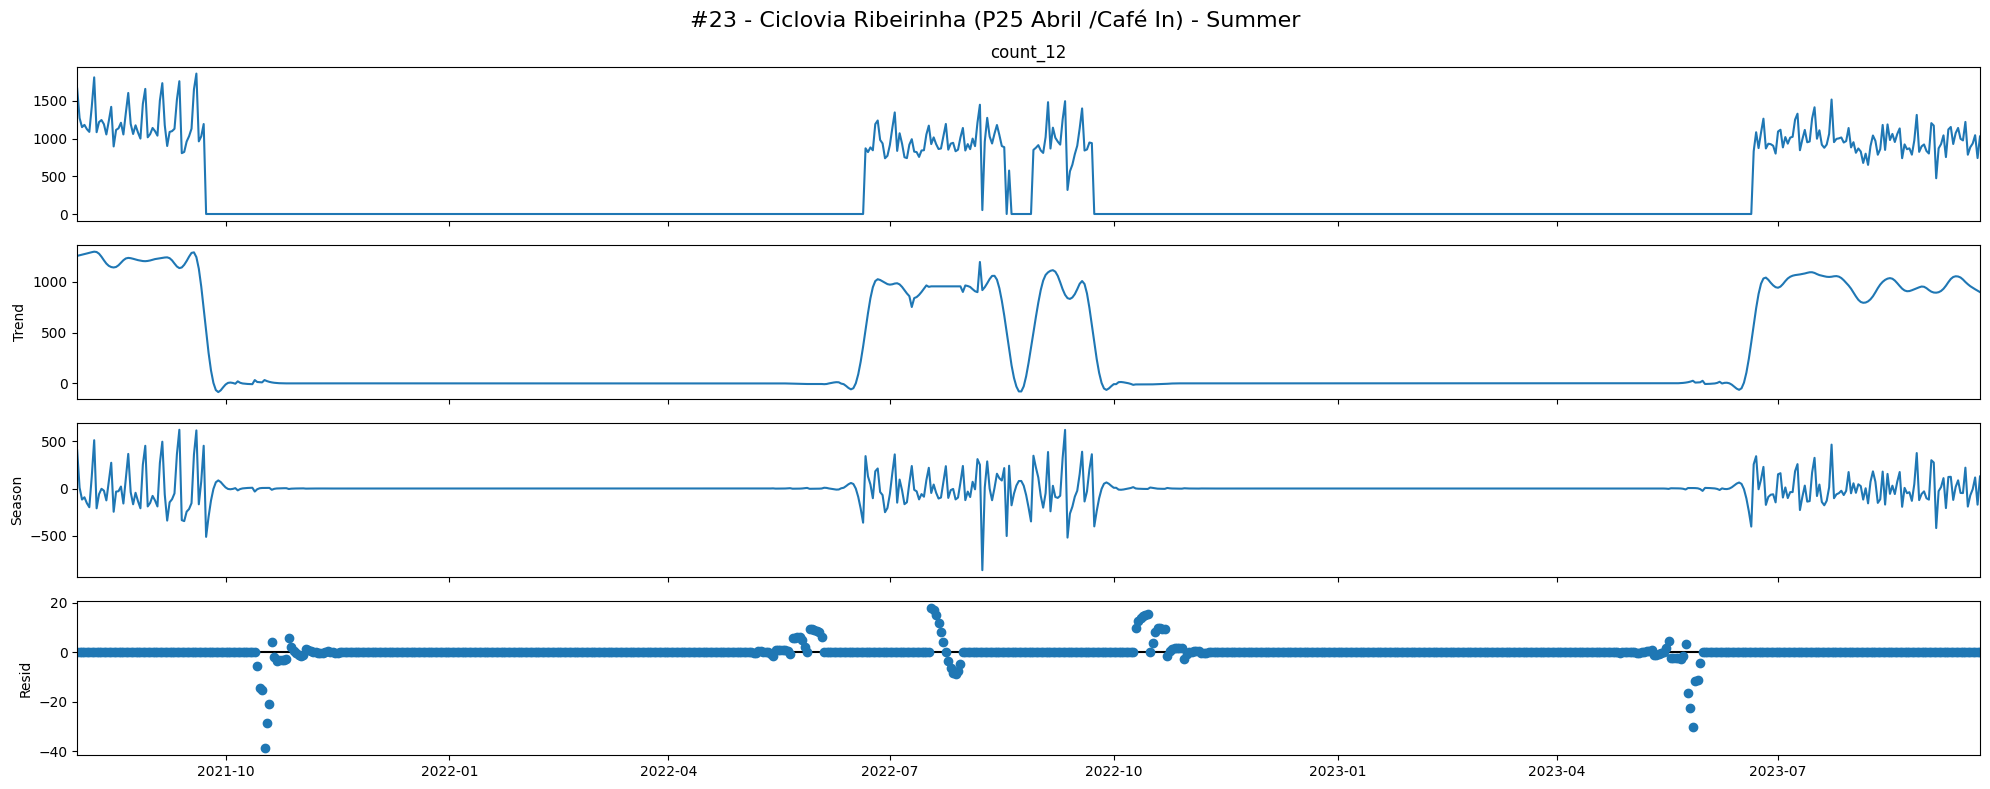

In [9]:
location_id = 12  

location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]  # Obtém o nome da localização

df_summer = df[(df.index.month == 6) & (df.index.day >= 21) |
               (df.index.month == 7) |
               (df.index.month == 8) |
               (df.index.month == 9) & (df.index.day <= 22)]


# Agrega os dados por dia
contador = f'count_{location_id}'
series_summer= df_summer.resample('D').sum()[contador]

# Aplicar a decomposição sazonal com período semanal (7 dias)
stl = STL(series_summer, period=7, robust=True)
res = stl.fit()

# Criar a figura 
fig = res.plot()
fig.set_size_inches(20, 8)

plt.suptitle(f'{location_name} - Summer', fontsize=16)
plt.tight_layout()
plt.show()


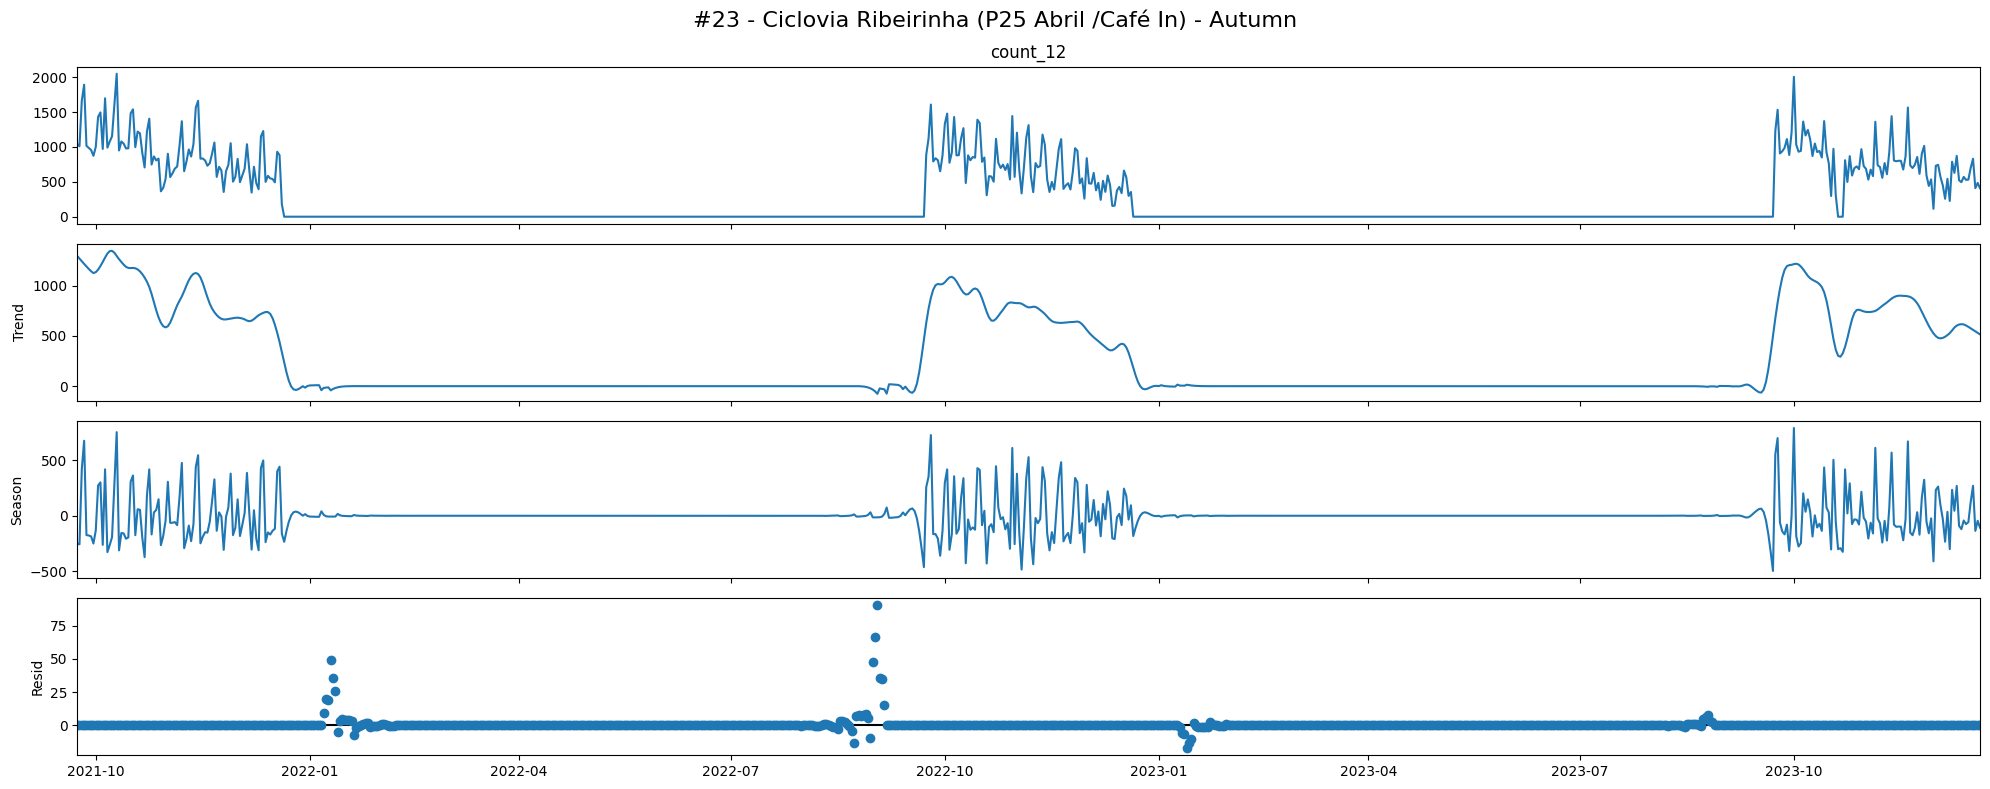

In [10]:
location_id = 12  

location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]  # Obtém o nome da localização

df_autumn = df[(df.index.month == 9) & (df.index.day >= 23) |
               (df.index.month == 10) |
               (df.index.month == 11) |
               (df.index.month == 12) & (df.index.day <= 20)]

# Agrega os dados por dia
contador = f'count_{location_id}'
series_autumn = df_autumn.resample('D').sum()[contador]

# Aplicar a decomposição sazonal com período semanal (7 dias)
stl = STL(series_autumn, period=7, robust=True)
res = stl.fit()

# Criar a figura 
fig = res.plot()
fig.set_size_inches(20, 8)
plt.suptitle(f'{location_name} - Autumn', fontsize=16)
plt.tight_layout()
plt.show()


#23 - Ciclovia Ribeirinha (P25 Abril /Café In)
Results #23 - Ciclovia Ribeirinha (P25 Abril /Café In) - week days:
detected
2021-08-02    96.864853
2021-08-03     9.769567
2021-08-04   -41.409297
2021-08-05   -17.916400
2021-08-06   -50.819376
Name: season, dtype: float64


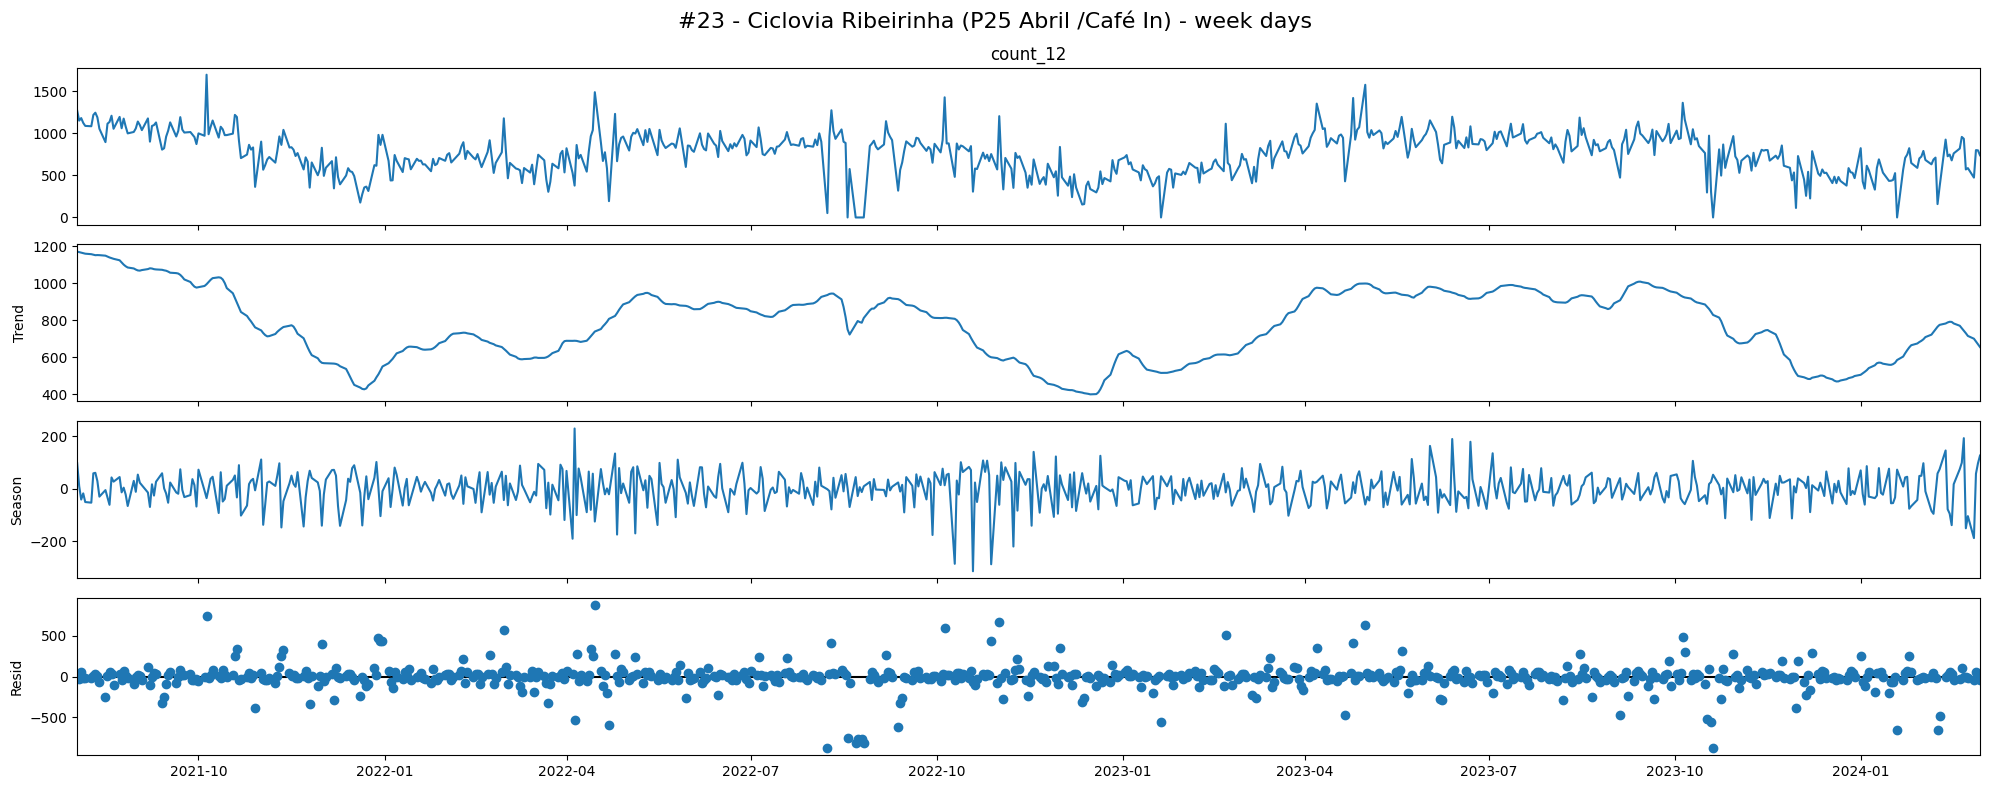

#23 - Ciclovia Ribeirinha (P25 Abril /Café In)
Results #23 - Ciclovia Ribeirinha (P25 Abril /Café In) - weekend:
detected
2021-08-01    113.800686
2021-08-07    -48.642858
2021-08-08    228.534944
2021-08-14   -207.878491
2021-08-15   -118.642975
Name: season, dtype: float64


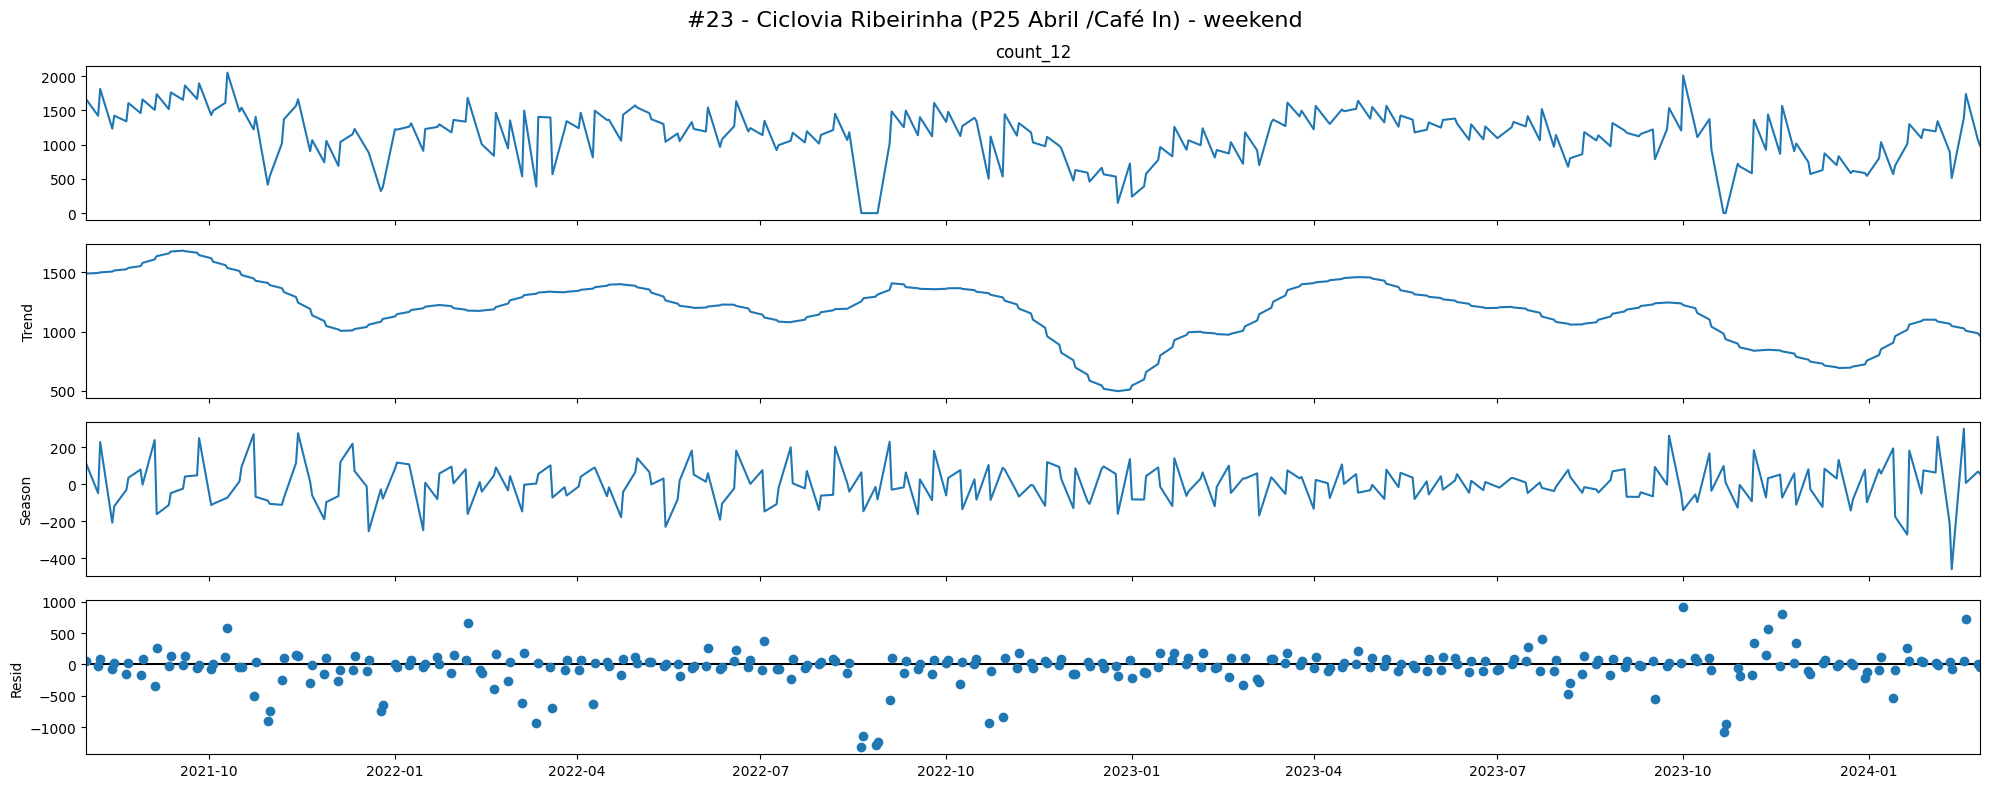

#07 - Jardim do Campo Grande
Results #07 - Jardim do Campo Grande - week days:
detected
2021-08-02    11.586186
2021-08-03    -7.818224
2021-08-04   -16.639651
2021-08-05    -0.641183
2021-08-06    18.012461
Name: season, dtype: float64


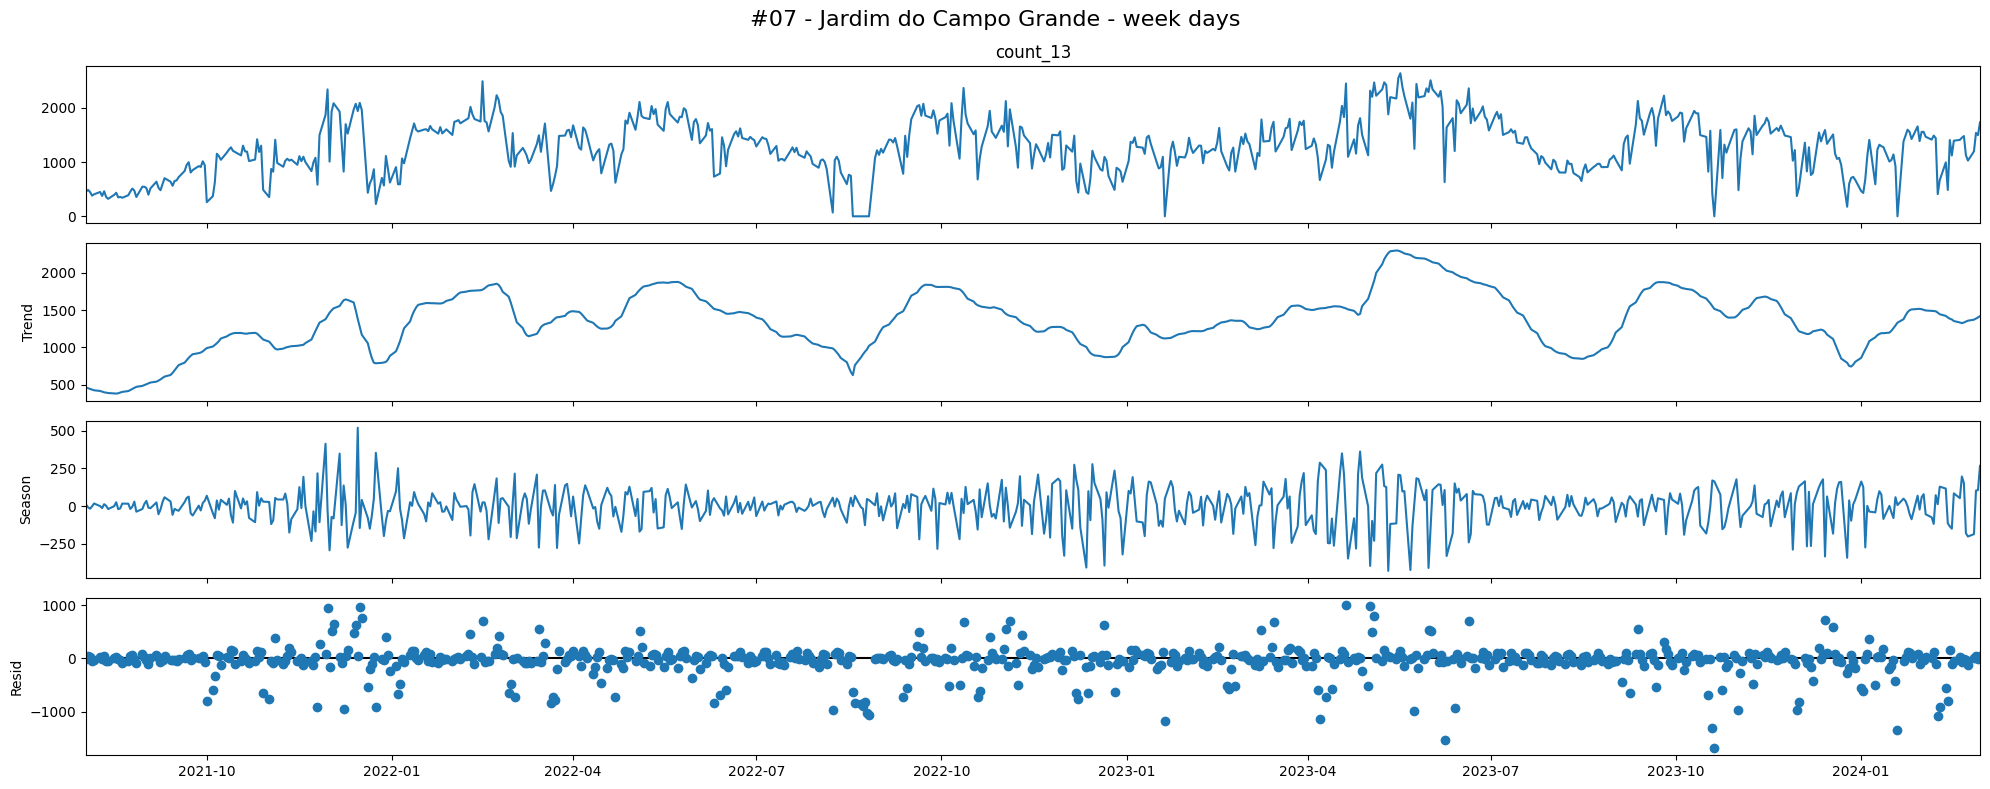

#07 - Jardim do Campo Grande
Results #07 - Jardim do Campo Grande - weekend:
detected
2021-08-01    28.426401
2021-08-07    27.541751
2021-08-08    25.805360
2021-08-14   -26.823360
2021-08-15   -93.666722
Name: season, dtype: float64


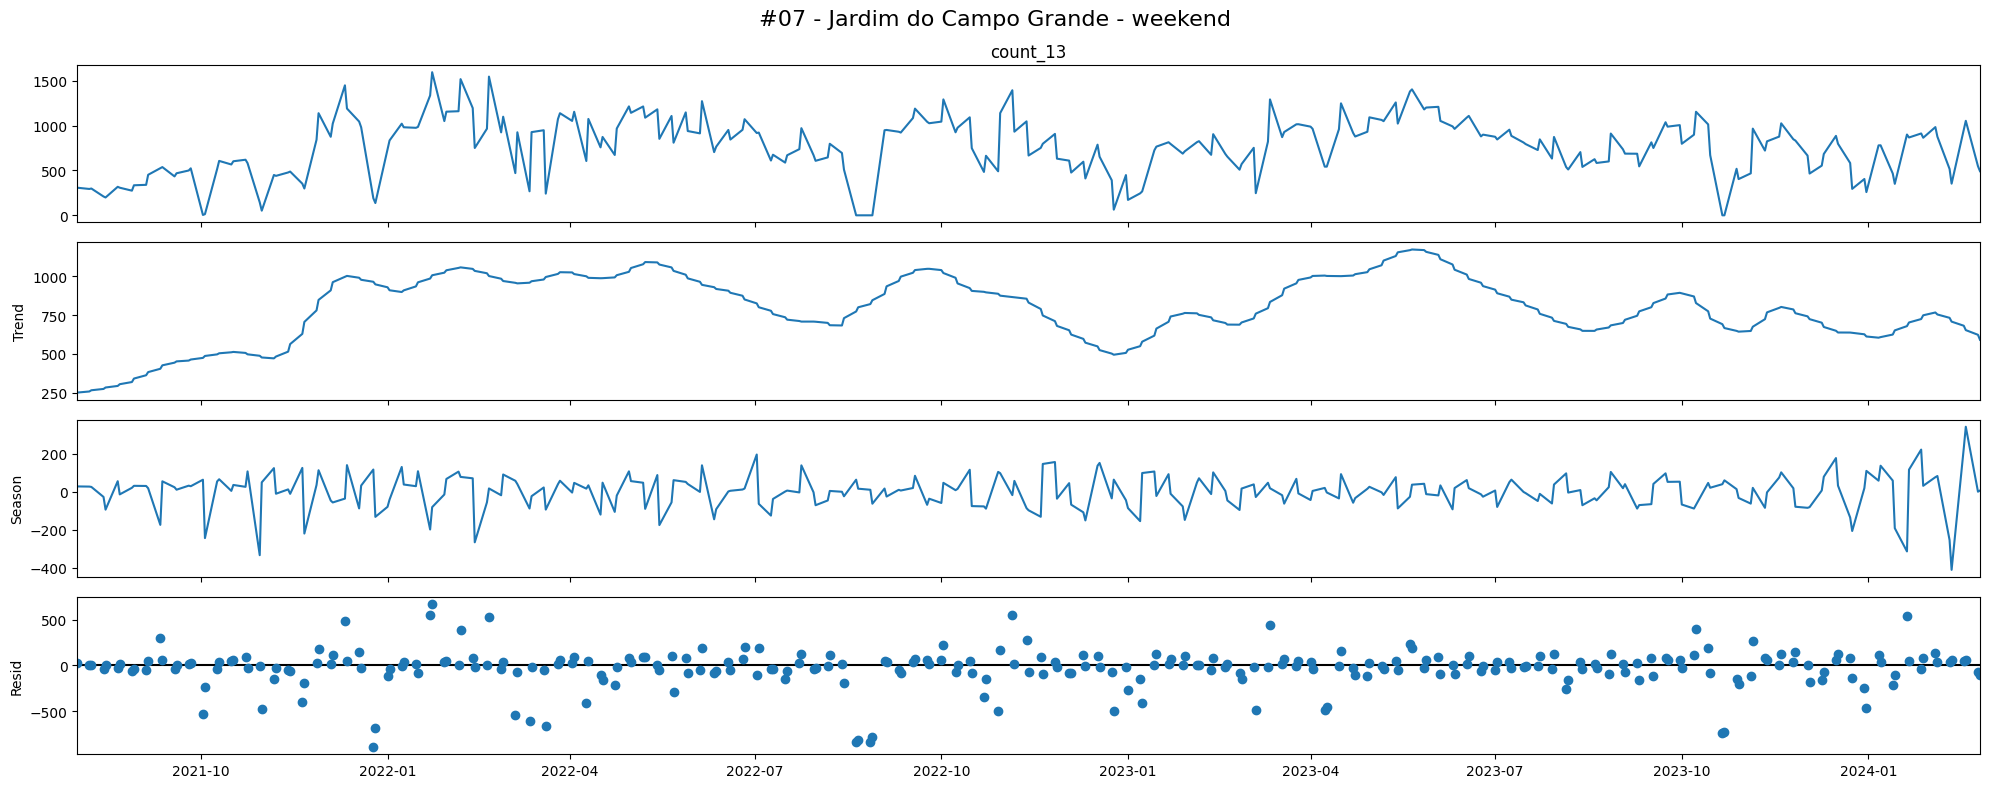

In [10]:
location_ids = [12, 13]  # Substitua pelos locationIds desejados

# Loop para aplicar STL aos contadores selecionados
for location_id in location_ids:
    # Verifica se a coluna correspondente ao location_id existe
    contador = f"count_{location_id}"

    if contador in df_daily.columns:
        location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]  # Obtém o nome da localização
        series = df_daily[contador]

        # Divide os dados entre dias úteis e fins de semana
        weekdays = series[series.index.weekday < 5]  # Dias úteis (segunda a sexta-feira)
        weekends = series[series.index.weekday >= 5]  # Fins de semana (sábado e domingo)

        # Função para aplicar STL e gerar gráfico
        def apply_stl_and_plot(data, title):
            stl = STL(data, period=7, robust=True)
            res = stl.fit()

            # Exibe os primeiros valores da decomposição sazonal
            print(f"Results {title}:")
            print(res.seasonal.head())

            # Grafico
            fig = res.plot()
            fig.set_size_inches((20, 8))
            plt.suptitle(title, fontsize=16)
            plt.tight_layout()
            plt.show()

        # Aplica STL para os dias úteis
        print(f"{location_name}")
        apply_stl_and_plot(weekdays, f"{location_name} - week days")

        # Aplica STL para os fins de semana
        print(f"{location_name}")
        apply_stl_and_plot(weekends, f"{location_name} - weekend")
